<a href="https://colab.research.google.com/github/shubhkushwaha/RAG_attention-based_contectual-text-summerization/blob/main/rag_summerization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies with proper version management
!pip install -q transformers datasets sentence-transformers faiss-cpu rank_bm25 evaluate bert_score rouge_score
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q matplotlib seaborn plotly pandas

# Clear any previous installations
import gc
gc.collect()

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.0 MB/s eta 0:00:00


0

In [2]:
# Imports and Memory Mgmt
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForSeq2SeqLM
from sentence_transformers import SentenceTransformer, CrossEncoder
from datasets import load_dataset
from rank_bm25 import BM25Okapi
import faiss
import numpy as np
import evaluate
import random
import gc
import warnings
warnings.filterwarnings('ignore')

# Clear GPU cache and memory
def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

clear_memory()

# Device check with proper initialization
if torch.cuda.is_available():
    device = "cuda"
    torch.cuda.set_device(0)
    print(f"Using device: {device}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Available memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    device = "cpu"
    print("Using device: CPU")

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Using device: cuda
GPU: Tesla T4
Available memory: 14.74 GB


In [3]:
#Configuration (OPTIMIZED)
# Modes: demo_repro (CNN/DailyMail subset)
MODE = "demo_repro"   # options: "demo_fast", "demo_repro"

# Optimized subset size based on GPU memory
SUBSET_SIZE = 500 if device == "cuda" else 100  # Reduced for stability

GEN_MODEL = "t5-base"

# Retrieval parameters (optimized)
BM25_K = 50  # Reduced from 100
DENSE_K = 50  # Reduced from 100
CROSS_RANK_TOP = 5

# Batch sizes for memory efficiency
ENCODING_BATCH_SIZE = 16 if device == "cuda" else 8
GENERATION_BATCH_SIZE = 4 if device == "cuda" else 2

print(f"Mode: {MODE}, Generator: {GEN_MODEL}, Subset size: {SUBSET_SIZE}")
print(f"Device: {device}, Encoding batch: {ENCODING_BATCH_SIZE}")

Mode: demo_repro, Generator: t5-base, Subset size: 500
Device: cuda, Encoding batch: 16


In [4]:
#Data Loading and Chunking (MEMORY EFFICIENT)
from datasets import load_dataset
import time

# Inline chunker (optimized)
def chunk_documents(docs, chunk_size=128, overlap=20):
    chunks = []
    for doc in docs:
        if not isinstance(doc, str) or len(doc.strip()) == 0:
            continue
        words = doc.split()
        step = chunk_size - overlap
        for i in range(0, len(words), step):
            chunk = " ".join(words[i:i+chunk_size])
            # Keep only reasonably long chunks
            if len(chunk.split()) > 20:
                chunks.append(chunk)
    return chunks

# Safety checks
try:
    MODE
except NameError:
    raise RuntimeError("Please set MODE and SUBSET_SIZE in the config cell first.")

if MODE != "demo_repro":
    print("MODE is not 'demo_repro'. This cell is meant to run only in demo_repro mode.")
else:
    # Clear memory before loading
    clear_memory()

    print(f"Loading cnn_dailymail train[:{SUBSET_SIZE}] ... ")
    t0 = time.time()

    # Load dataset with streaming for memory efficiency
    dataset = load_dataset("cnn_dailymail", "3.0.0", split=f"train[:{SUBSET_SIZE}]")
    texts = [ex["article"] for ex in dataset]

    print(f"Loaded {len(texts)} articles. Chunking into passages (chunk_size=128, overlap=20)...")
    corpus_chunks = chunk_documents(texts, chunk_size=128, overlap=20)

    # Clear intermediate variables
    del dataset, texts
    clear_memory()

    t1 = time.time()
    print(f"Total chunks created: {len(corpus_chunks)}  (time: {t1-t0:.1f}s)")

    # Show preview
    print("\nPreview (first 5 chunks, truncated to 300 chars each):\n")
    for i, c in enumerate(corpus_chunks[:5], 1):
        print(f"--- Chunk {i} ---")
        print(c[:300].replace("\n", " ") + ("..." if len(c) > 300 else ""))
        print()

Loading cnn_dailymail train[:500] ... 


README.md: 0.00B [00:00, ?B/s]

3.0.0/train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

3.0.0/validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

3.0.0/test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Loaded 500 articles. Chunking into passages (chunk_size=128, overlap=20)...
Total chunks created: 2920  (time: 33.7s)

Preview (first 5 chunks, truncated to 300 chars each):

--- Chunk 1 ---
LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappoi...

--- Chunk 2 ---
an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II,...

--- Chunk 3 ---
be reading about it." Radcliffe's earnings from the first five Potter films have been held in a trust fund which he has not been able to touch. Despite his growing fam

In [5]:
# BM25 Index (STABLE)
def build_bm25(chunks):
    tokenized = [c.split() for c in chunks]
    return BM25Okapi(tokenized)

print("Building BM25 index...")
bm25 = build_bm25(corpus_chunks)
print(f"BM25 index ready with {len(corpus_chunks)} chunks.")
clear_memory()

Building BM25 index...
BM25 index ready with 2920 chunks.


In [6]:
# FAISS Index (MEMORY OPTIMIZED)
def build_faiss(chunks, model_name, device="cpu", batch_size=16):
    print(f"Loading dense retrieval model: {model_name}")
    model = SentenceTransformer(model_name, device=device)

    print(f"Encoding {len(chunks)} chunks in batches of {batch_size}...")
    embeddings = model.encode(
        chunks,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True  # L2 normalization for better retrieval
    )

    dim = embeddings.shape[1]
    print(f"Embedding dimension: {dim}")

    # Build FAISS index
    index = faiss.IndexFlatL2(dim)
    index.add(embeddings)

    return index, model, embeddings

dense_model_name = "sentence-transformers/all-mpnet-base-v2"
faiss_index, dense_model, corpus_embeddings = build_faiss(
    corpus_chunks,
    dense_model_name,
    device=device,
    batch_size=ENCODING_BATCH_SIZE
)
print(f"FAISS index ready with {faiss_index.ntotal} vectors.")
clear_memory()

Loading dense retrieval model: sentence-transformers/all-mpnet-base-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding 2920 chunks in batches of 16...


Batches:   0%|          | 0/183 [00:00<?, ?it/s]

Embedding dimension: 768
FAISS index ready with 2920 vectors.


In [7]:
# Cross-Encoder Reranker (STABLE)
print("Loading cross-encoder reranker...")
reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2", device=device)
print("Cross-Encoder ready.")
clear_memory()

Loading cross-encoder reranker...


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Cross-Encoder ready.


In [8]:
#Hybrid Retrieval Function (OPTIMIZED)
def retrieve_hybrid(query, corpus, bm25, faiss_index, dense_model, reranker,
                    bm25_k=50, dense_k=50, cross_rank_top=5, device="cpu"):
    """
    Hybrid retrieval combining BM25, dense retrieval, and cross-encoder reranking.
    """
    # BM25 sparse retrieval
    bm25_scores = bm25.get_scores(query.split())
    bm25_top = np.argsort(bm25_scores)[::-1][:bm25_k]

    # Dense retrieval with FAISS
    q_emb = dense_model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    D, I = faiss_index.search(q_emb, dense_k)
    dense_top = I[0]

    # Union of candidates
    candidates = list(set(bm25_top) | set(dense_top))
    cand_texts = [corpus[i] for i in candidates]

    # Cross-encoder reranking
    if len(cand_texts) > 0:
        scores = reranker.predict([(query, t) for t in cand_texts])
        sorted_idx = np.argsort(scores)[::-1][:cross_rank_top]
        return [cand_texts[i] for i in sorted_idx], scores[sorted_idx]
    else:
        return [], []

def demo_retrieve(query, top_k=5):
    """Wrapper for retrieval with default parameters."""
    results, scores = retrieve_hybrid(
        query, corpus_chunks, bm25, faiss_index, dense_model, reranker,
        bm25_k=BM25_K, dense_k=DENSE_K, cross_rank_top=top_k, device=device
    )
    return results, scores

# Test retrieval
test_results, test_scores = demo_retrieve("climate change and global warming", top_k=3)
print(f"\nTest retrieval returned {len(test_results)} passages")
for i, (passage, score) in enumerate(zip(test_results, test_scores), 1):
    print(f"{i}. Score: {score:.4f} | {passage[:150]}...")


Test retrieval returned 3 passages
1. Score: 4.9711 | to be an example of climate change." "The other thing was that it meant it was really happening. It wasn't a joke. It wasn't just statistics. It was r...
2. Score: 3.0557 | taken to reading tea leaves," he said. "When we saw cooling from 1940 to 1970, we were proclaiming global cooling. Since then, there's been a few tent...
3. Score: 1.6441 | 1910, according to the U.S. Environmental Protection Agency. They rose till about 1945, cooled until about 1975 and have risen steadily to present day...


In [9]:
#Attention-Based Fusion Module (ARCHITECTURE)
import torch.nn as nn

class CrossAttentionFusion(nn.Module):
    """
    Cross-attention fusion module for integrating retrieved context with query.
    """
    def __init__(self, d_model=768, n_heads=8, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model*4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model*4, d_model)
        )
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, context):
        # Cross-attention
        attn_out, attn_weights = self.attn(query, context, context)
        x = self.ln1(query + self.dropout(attn_out))

        # Feed-forward network
        ffn_out = self.ffn(x)
        out = self.ln2(x + self.dropout(ffn_out))

        return out, attn_weights

# Initialize fusion module
fusion = CrossAttentionFusion(d_model=768, n_heads=8, dropout=0.1).to(device)

# Test fusion module
dummy_q = torch.rand(1, 10, 768).to(device)
dummy_ctx = torch.rand(1, 15, 768).to(device)
fused, attn_weights = fusion(dummy_q, dummy_ctx)

print(" Cross-Attention Fusion Module initialized")
print(f"  Input query shape: {dummy_q.shape}")
print(f"  Input context shape: {dummy_ctx.shape}")
print(f"  Fused representation shape: {fused.shape}")
print(f"  Attention weights shape: {attn_weights.shape}")

clear_memory()

 Cross-Attention Fusion Module initialized
  Input query shape: torch.Size([1, 10, 768])
  Input context shape: torch.Size([1, 15, 768])
  Fused representation shape: torch.Size([1, 10, 768])
  Attention weights shape: torch.Size([1, 10, 15])


In [10]:
#  Generator Model (MEMORY EFFICIENT)
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

def load_generator(model_name, device="cpu"):
    """Load T5 generator with memory optimization."""
    print(f"Loading generator: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16 if device == "cuda" else torch.float32
    ).to(device)
    print(f"Generator loaded on {device}")
    return tokenizer, model

# Load generator
tokenizer, generator_model = load_generator(GEN_MODEL, device=device)

def generate_summary(text, max_len=128, num_beams=4):
    """Generate summary with memory management."""
    # Encode input
    inputs = tokenizer(
        "summarize: " + text,
        return_tensors="pt",
        truncation=True,
        max_length=512
    ).to(device)

    # Generate
    with torch.no_grad():
        summary_ids = generator_model.generate(
            inputs["input_ids"],
            max_length=max_len,
            num_beams=num_beams,
            early_stopping=True,
            no_repeat_ngram_size=3
        )

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Clear memory
    del inputs, summary_ids
    clear_memory()

    return summary

# Test generation
test_summary = generate_summary(
    "The Eiffel Tower is in Paris. It was built in 1889 and is one of the most famous landmarks in the world."
)
print(f"\nTest summary: {test_summary}")

Loading generator: t5-base


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Generator loaded on cuda

Test summary: the Eiffel Tower was built in 1889 . it is one of the most famous landmarks in the world .


In [11]:
# Hybrid Summarization Pipeline
def demo_summarize(article, top_k=5, use_hybrid=True, max_len=128, verbose=True):
    """
    Complete hybrid summarization pipeline with retrieval and generation.
    """
    # Expand query if too short
    query = article if len(article.split()) > 6 else "Article about " + article

    # Retrieve passages
    if use_hybrid:
        retrieved, scores = demo_retrieve(query, top_k=top_k)
    else:
        retrieved = [article]
        scores = [1.0]

    # Concatenate retrieved passages (truncate for T5 input)
    combined_input = " ".join(retrieved)[:2000]

    # Generate summary
    summary = generate_summary(combined_input, max_len=max_len)

    # Display results
    if verbose:
        print("\n" + "="*80)
        print("HYBRID RAG SUMMARIZATION")
        print("="*80)
        print(f"\nQuery: {query[:200]}...")
        print(f"\nRetrieved {len(retrieved)} passages:")
        for i, (passage, score) in enumerate(zip(retrieved, scores), 1):
            print(f"\n  {i}. [Score: {score:.4f}]")
            print(f"     {passage[:200]}...")
        print(f"\nGenerated Summary:")
        print(f"   {summary}")
        print("\n" + "="*80)

    return summary, retrieved, scores

# Example runs
print("\n Example 1: News Article")
demo_summarize("Climate change and global warming effects on environment")

print("\n\nExample 2: General Topic")
demo_summarize("Artificial intelligence and machine learning applications")


 Example 1: News Article

HYBRID RAG SUMMARIZATION

Query: Climate change and global warming effects on environment...

Retrieved 5 passages:

  1. [Score: 2.1987]
     to be an example of climate change." "The other thing was that it meant it was really happening. It wasn't a joke. It wasn't just statistics. It was really happening." He calls his discovery Warming I...

  2. [Score: 0.8080]
     1910, according to the U.S. Environmental Protection Agency. They rose till about 1945, cooled until about 1975 and have risen steadily to present day. There are several possible reasons for the warmi...

  3. [Score: -0.7199]
     percent since the dawn of the industrial age, according to the United Nations' Intergovernmental Panel on Climate Change, commonly referred to as the IPCC. The presence of methane is now 151 percent a...

  4. [Score: -1.2144]
     taken to reading tea leaves," he said. "When we saw cooling from 1940 to 1970, we were proclaiming global cooling. Since then, there's 

("a student without basic fundamental technology skills is on equal footing for employment . technology is changing the world we live in all the time, and one of the places where those changes are taking place is schools . if teachers and school leaders use the same standards that they would use for any resource for technologies, then we're in fine shape .",
 ["DON KNEZEK, CEO, INTERNATIONAL SOCIETY FOR TECHNOLOGY IN EDUCATION: Certainly just dropping technology into a learning environment doesn't necessarily improve it unless you are sure that the activities that you are doing align with the expectations that you have for learning. AMMARAH MAHMOUD, JUNIOR, SALEM HIGH SCHOOL: I think many careers today require for people to know how to use technology, so it's important to learn that in school . KNEZEK: So you can't convince me that a student without basic fundamental technology skills is on equal footing for employment. MAHMOUD: I don't think schooling should be technology dependent, b

COMPREHENSIVE EVALUATION

Loading 20 validation samples...



Generating summaries (Hybrid: True)...
  Processed 5/20 samples...
  Processed 10/20 samples...
  Processed 15/20 samples...
  Processed 20/20 samples...

✓ Generation complete!

Computing metrics...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



ACCURACY REPORT

ROUGE SCORES:
  ROUGE-1: 0.0940
  ROUGE-2: 0.0041
  ROUGE-L: 0.0640

BERTScore (averaged):
  Precision: 0.8181
  Recall:    0.8260
  F1:        0.8220

LATENCY:
  Mean: 3.54s
  Median: 3.19s
  Std: 1.26s


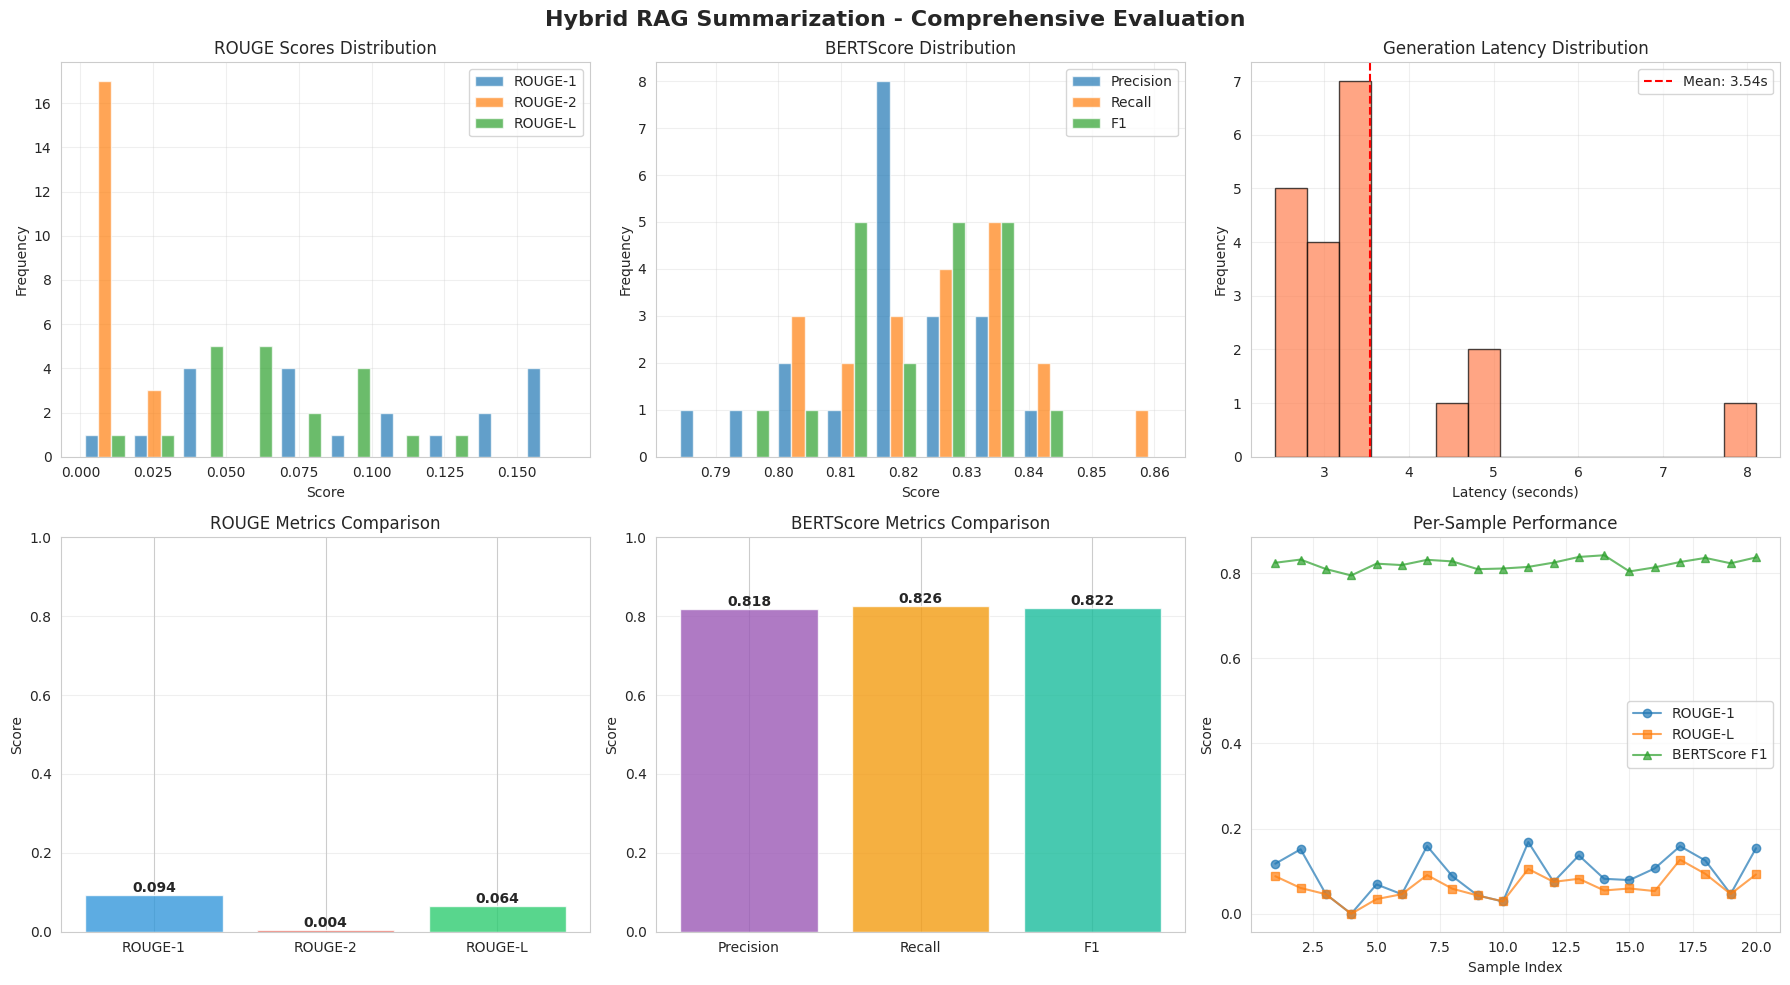


SUMMARY STATISTICS
      Metric     Mean      Std      Min      Max
     ROUGE-1 0.094042 0.049139 0.000000 0.168421
     ROUGE-2 0.004123 0.009977 0.000000 0.032787
     ROUGE-L 0.064049 0.029124 0.000000 0.126984
 BERTScore P 0.818136 0.013899 0.783578 0.839583
 BERTScore R 0.825987 0.014538 0.802697 0.861871
BERTScore F1 0.821978 0.012175 0.794551 0.841991
 Latency (s) 3.535160 1.255008 2.421102 8.100682


In [12]:
# Comprehensive Evaluation (NEW - need to work and optimise further)

import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pandas as pd

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

def comprehensive_evaluation(num_samples=20, use_hybrid=True):
    """
    Run comprehensive evaluation with multiple metrics and visualizations.
    """
    print("="*80)
    print("COMPREHENSIVE EVALUATION")
    print("="*80)

    # Load evaluation data
    print(f"\nLoading {num_samples} validation samples...")
    valset = load_dataset("cnn_dailymail", "3.0.0", split=f"validation[:{num_samples}]")

    # Initialize metrics
    rouge = evaluate.load("rouge")
    bertscore = evaluate.load("bertscore")

    # Storage for results
    refs, preds = [], []
    rouge_scores_per_sample = []
    bert_scores_per_sample = []
    latencies = []

    print(f"\nGenerating summaries (Hybrid: {use_hybrid})...")

    for idx, ex in enumerate(valset):
        # Time the summarization
        import time
        start_time = time.time()

        if use_hybrid:
            summary, retrieved, scores = demo_summarize(
                ex["article"],
                top_k=5,
                use_hybrid=True,
                verbose=False
            )
        else:
            summary = generate_summary(ex["article"], max_len=128)

        latency = time.time() - start_time
        latencies.append(latency)

        refs.append(ex["highlights"])
        preds.append(summary)

        # Per-sample ROUGE
        sample_rouge = rouge.compute(predictions=[summary], references=[ex["highlights"]])
        rouge_scores_per_sample.append(sample_rouge)

        # Progress
        if (idx + 1) % 5 == 0:
            print(f"  Processed {idx + 1}/{num_samples} samples...")

    print("\n✓ Generation complete!")

    # Compute aggregate metrics
    print("\nComputing metrics...")
    rouge_results = rouge.compute(predictions=preds, references=refs)
    bert_results = bertscore.compute(predictions=preds, references=refs, lang="en")

    # === ACCURACY REPORT ===
    print("\n" + "="*80)
    print("ACCURACY REPORT")
    print("="*80)

    print("\nROUGE SCORES:")
    print(f"  ROUGE-1: {rouge_results['rouge1']:.4f}")
    print(f"  ROUGE-2: {rouge_results['rouge2']:.4f}")
    print(f"  ROUGE-L: {rouge_results['rougeL']:.4f}")

    print("\nBERTScore (averaged):")
    print(f"  Precision: {np.mean(bert_results['precision']):.4f}")
    print(f"  Recall:    {np.mean(bert_results['recall']):.4f}")
    print(f"  F1:        {np.mean(bert_results['f1']):.4f}")

    print("\nLATENCY:")
    print(f"  Mean: {np.mean(latencies):.2f}s")
    print(f"  Median: {np.median(latencies):.2f}s")
    print(f"  Std: {np.std(latencies):.2f}s")

    # === VISUALIZATIONS ===
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Hybrid RAG Summarization - Comprehensive Evaluation', fontsize=16, fontweight='bold')

    # 1. ROUGE Scores Distribution
    rouge1_scores = [s['rouge1'] for s in rouge_scores_per_sample]
    rouge2_scores = [s['rouge2'] for s in rouge_scores_per_sample]
    rougeL_scores = [s['rougeL'] for s in rouge_scores_per_sample]

    axes[0, 0].hist([rouge1_scores, rouge2_scores, rougeL_scores],
                    label=['ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
                    alpha=0.7, bins=10)
    axes[0, 0].set_xlabel('Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('ROUGE Scores Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. BERTScore Distribution
    axes[0, 1].hist([bert_results['precision'], bert_results['recall'], bert_results['f1']],
                    label=['Precision', 'Recall', 'F1'],
                    alpha=0.7, bins=10)
    axes[0, 1].set_xlabel('Score')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('BERTScore Distribution')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Latency Distribution
    axes[0, 2].hist(latencies, bins=15, color='coral', alpha=0.7, edgecolor='black')
    axes[0, 2].axvline(np.mean(latencies), color='red', linestyle='--', label=f'Mean: {np.mean(latencies):.2f}s')
    axes[0, 2].set_xlabel('Latency (seconds)')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Generation Latency Distribution')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. ROUGE Comparison Bar Chart
    metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
    scores = [rouge_results['rouge1'], rouge_results['rouge2'], rouge_results['rougeL']]
    bars = axes[1, 0].bar(metrics, scores, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.8)
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].set_title('ROUGE Metrics Comparison')
    axes[1, 0].set_ylim([0, 1])
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

    # 5. BERTScore Comparison
    bert_metrics = ['Precision', 'Recall', 'F1']
    bert_values = [np.mean(bert_results['precision']),
                   np.mean(bert_results['recall']),
                   np.mean(bert_results['f1'])]
    bars = axes[1, 1].bar(bert_metrics, bert_values, color=['#9b59b6', '#f39c12', '#1abc9c'], alpha=0.8)
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('BERTScore Metrics Comparison')
    axes[1, 1].set_ylim([0, 1])
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    for bar in bars:
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

    # 6. Sample-wise Performance
    sample_indices = list(range(1, len(rouge1_scores) + 1))
    axes[1, 2].plot(sample_indices, rouge1_scores, marker='o', label='ROUGE-1', alpha=0.7)
    axes[1, 2].plot(sample_indices, rougeL_scores, marker='s', label='ROUGE-L', alpha=0.7)
    axes[1, 2].plot(sample_indices, bert_results['f1'], marker='^', label='BERTScore F1', alpha=0.7)
    axes[1, 2].set_xlabel('Sample Index')
    axes[1, 2].set_ylabel('Score')
    axes[1, 2].set_title('Per-Sample Performance')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # === SUMMARY STATISTICS TABLE ===
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)

    stats_data = {
        'Metric': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BERTScore P', 'BERTScore R', 'BERTScore F1', 'Latency (s)'],
        'Mean': [
            rouge_results['rouge1'],
            rouge_results['rouge2'],
            rouge_results['rougeL'],
            np.mean(bert_results['precision']),
            np.mean(bert_results['recall']),
            np.mean(bert_results['f1']),
            np.mean(latencies)
        ],
        'Std': [
            np.std(rouge1_scores),
            np.std(rouge2_scores),
            np.std(rougeL_scores),
            np.std(bert_results['precision']),
            np.std(bert_results['recall']),
            np.std(bert_results['f1']),
            np.std(latencies)
        ],
        'Min': [
            np.min(rouge1_scores),
            np.min(rouge2_scores),
            np.min(rougeL_scores),
            np.min(bert_results['precision']),
            np.min(bert_results['recall']),
            np.min(bert_results['f1']),
            np.min(latencies)
        ],
        'Max': [
            np.max(rouge1_scores),
            np.max(rouge2_scores),
            np.max(rougeL_scores),
            np.max(bert_results['precision']),
            np.max(bert_results['recall']),
            np.max(bert_results['f1']),
            np.max(latencies)
        ]
    }

    df = pd.DataFrame(stats_data)
    print(df.to_string(index=False))

    return rouge_results, bert_results, latencies

# Run evaluation
if MODE == "demo_repro":
    rouge_results, bert_results, latencies = comprehensive_evaluation(num_samples=20, use_hybrid=True)
else:
    print("Evaluation only runs in demo_repro mode.")

In [18]:
# Interactive Summarize Module
import ipywidgets as widgets
from IPython.display import display, clear_output

def run_summarizer(_):
    clear_output(wait=True)
    print("=== Hybrid RAG Summarization Demo ===\n")

    query = text_box.value.strip()
    if not query:
        print(" Please enter some text or a query to summarize.")
        return

    print("Processing... (this may take a few seconds)\n")

    try:
        summary, retrieved, scores = demo_summarize(query, top_k=5, use_hybrid=True, max_len=128, verbose=False)

        print(" Input Text:")
        print(query[:600] + ("..." if len(query) > 600 else ""))
        print("\n" + "-" * 70)

        print("\n Retrieved Passages:")
        for i, (p, s) in enumerate(zip(retrieved, scores), 1):
            snippet = p[:300].replace("\n", " ")
            print(f"{i}. [Score: {s:.4f}] {snippet}...")
        print("\n" + "-" * 70)

        print("\n Generated Summary:")
        print(summary)
        print("\n" + "-" * 70)

        print(f"Summary Length: {len(summary.split())} words")
        print(f"Compression Ratio: {len(query.split()) / len(summary.split()):.2f}x")

    except Exception as e:
        print("Error:", e)

# Simple text area
text_box = widgets.Textarea(
    value="",
    placeholder="Enter article text or topic here...",
    layout=widgets.Layout(width="100%", height="120px")
)

# Run button
run_button = widgets.Button(description="Generate Summary", button_style="success")
run_button.on_click(run_summarizer)

# Display interface
print("Simple Interactive Summarizer (Hybrid RAG Pipeline)")
display(text_box, run_button)


=== Hybrid RAG Summarization Demo ===

Processing... (this may take a few seconds)

 Input Text:
Sustainable AI future

----------------------------------------------------------------------

 Retrieved Passages:
1. [Score: -10.5560] wild plants, as opposed to the seeds of crops. Paul Smith, the leader of the Millennium Seed Bank project, said preserving the seeds of wild plants is just as important as preserving the seeds of vital crops. "We must give ourselves every option in the future to use the whole array of plant diversit...
2. [Score: -10.7657] Green Building Council establishes a rating system for efficient buildings called LEED, or Leadership in Energy and Environmental Design. The Greensburg facility is aiming for LEED platinum, the most demanding standard. There is one wind turbine on their new property, a 100-foot structure designed t...
3. [Score: -10.8394] ever get my hope back. I didn't have a future." He adds, "I want to go to America and meet this person that gave me 


🔬 Running Retrieval Relevance Analysis...

RETRIEVAL RELEVANCE ANALYSIS


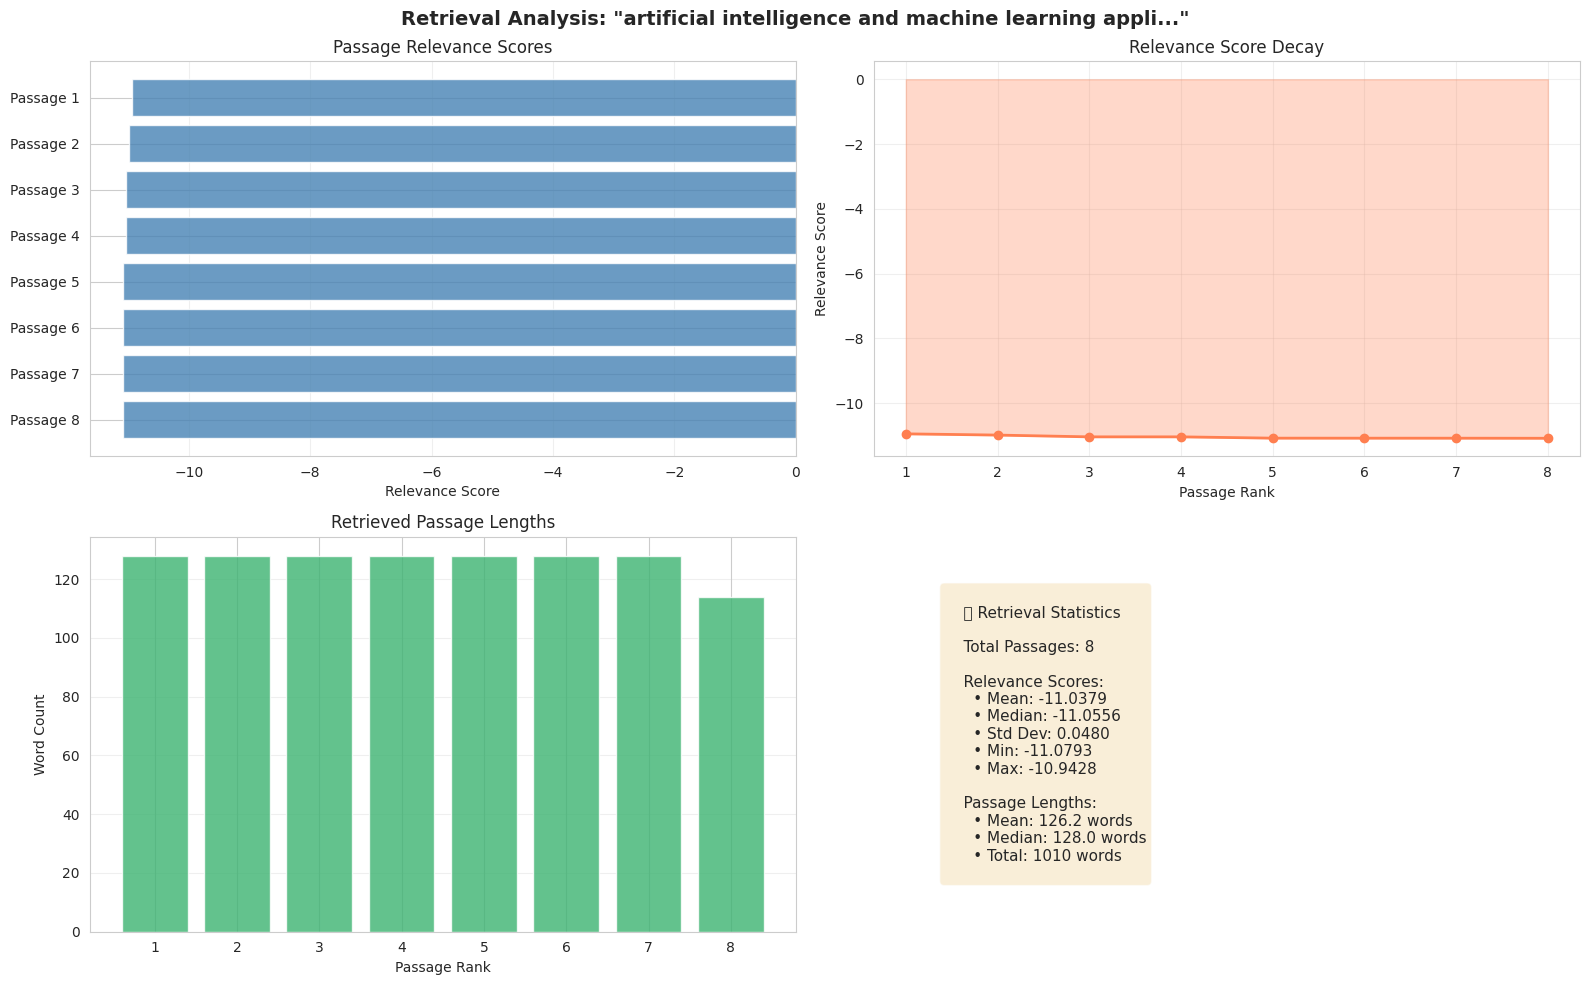


📄 RETRIEVED PASSAGES (Detailed):

1. Relevance Score: -10.9428 | Length: 128 words
   smaller computers. Advances in technology are changing the world we live in all the time. And one of the places where those changes are taking place is schools. So we talked to some students and experts to hear what they have to say about teaching with tech. (BEGIN VIDEO CLIP) TRINA DAVIS, PRESIDENT, INTERNATIONAL SOCIETY FOR TECHNOLOGY IN EDUCATION: We started off, when we were first starting to ...
--------------------------------------------------------------------------------

2. Relevance Score: -10.9807 | Length: 128 words
   shouldn't rely on something that doesn't have a mind of its own. KNEZEK: You can certainly abuse technology. You can abuse the printed word. You can abuse access to external resources. Certainly if teachers and school leaders and parents use the same standards that they would use for any resource for technologies, then we're in fine shape. LEWIS: I can see people in the fu

In [14]:
# @title
# Cell 14: Relevance Analysis Visualization (NEW)
def analyze_retrieval_relevance(query, top_k=10):
    """
    Analyze and visualize retrieval relevance for a given query.
    """
    print("="*80)
    print("RETRIEVAL RELEVANCE ANALYSIS")
    print("="*80)

    # Retrieve passages
    retrieved, scores = demo_retrieve(query, top_k=top_k)

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'Retrieval Analysis: "{query[:50]}..."', fontsize=14, fontweight='bold')

    # 1. Relevance scores distribution
    axes[0, 0].barh(range(len(scores)), scores, color='steelblue', alpha=0.8)
    axes[0, 0].set_yticks(range(len(scores)))
    axes[0, 0].set_yticklabels([f'Passage {i+1}' for i in range(len(scores))])
    axes[0, 0].set_xlabel('Relevance Score')
    axes[0, 0].set_title('Passage Relevance Scores')
    axes[0, 0].grid(True, alpha=0.3, axis='x')
    axes[0, 0].invert_yaxis()

    # 2. Score decay curve
    axes[0, 1].plot(range(1, len(scores)+1), scores, marker='o', linewidth=2, color='coral')
    axes[0, 1].fill_between(range(1, len(scores)+1), scores, alpha=0.3, color='coral')
    axes[0, 1].set_xlabel('Passage Rank')
    axes[0, 1].set_ylabel('Relevance Score')
    axes[0, 1].set_title('Relevance Score Decay')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Passage length distribution
    lengths = [len(p.split()) for p in retrieved]
    axes[1, 0].bar(range(1, len(lengths)+1), lengths, color='mediumseagreen', alpha=0.8)
    axes[1, 0].set_xlabel('Passage Rank')
    axes[1, 0].set_ylabel('Word Count')
    axes[1, 0].set_title('Retrieved Passage Lengths')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # 4. Score statistics
    stats_text = f"""
    📊 Retrieval Statistics

    Total Passages: {len(retrieved)}

    Relevance Scores:
      • Mean: {np.mean(scores):.4f}
      • Median: {np.median(scores):.4f}
      • Std Dev: {np.std(scores):.4f}
      • Min: {np.min(scores):.4f}
      • Max: {np.max(scores):.4f}

    Passage Lengths:
      • Mean: {np.mean(lengths):.1f} words
      • Median: {np.median(lengths):.1f} words
      • Total: {sum(lengths)} words
    """

    axes[1, 1].text(0.1, 0.5, stats_text, transform=axes[1, 1].transAxes,
                   fontsize=11, verticalalignment='center',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Print detailed passage information
    print("\n📄 RETRIEVED PASSAGES (Detailed):")
    print("="*80)
    for i, (passage, score) in enumerate(zip(retrieved, scores), 1):
        print(f"\n{i}. Relevance Score: {score:.4f} | Length: {len(passage.split())} words")
        print(f"   {passage[:400]}{'...' if len(passage) > 400 else ''}")
        print("-"*80)

# Test retrieval analysis
print("\n🔬 Running Retrieval Relevance Analysis...\n")
analyze_retrieval_relevance("artificial intelligence and machine learning applications", top_k=8)